# Prediction notebook

----------------------
This notebook allows for predictions on large images. It includes the tiling of those images either without smooth blending or with smooth blending

To do for later use:

- Smooth blending only works on very small images. Why? Can we improve?
- The predict function does currently not work with pretrained versions of the model

In [ ]:
from patchify import patchify, unpatchify
import cv2
import numpy as np
from matplotlib import pyplot as plt
from keras.models import load_model
import os
import random

In [ ]:
#Load model
model = load_model('../models/StdUnet_diceplusfocal_epochs50_batchsize8_learningrate0.005.hdf5', compile=False)

In [ ]:
#Load all test images and masks
test_img_dir = '../data/data_original/test_data/image/'
test_msk_dir = '../data/data_original/test_data/mask/'

img_list = os.listdir(test_img_dir)
img_list.sort()
msk_list = os.listdir(test_msk_dir)
msk_list.sort()
num_images = len(os.listdir(test_img_dir))

In [ ]:
# Load one random quarter for fast testing
img_num = random.randint(0, num_images-1)
img_for_test = cv2.imread(test_img_dir+img_list[img_num], 0)
mask_for_test =cv2.imread(test_msk_dir+msk_list[img_num], 0)

In [23]:
#Predict on large image
#This will split the image into small images of shape [3,3]
patches = patchify(img_for_test, (512, 512), step=512) 
print("Large image shape is: ", img_for_test.shape)
print("Patches array shape is: ", patches.shape)

Large image shape is:  (3328, 4096)
Patches array shape is:  (6, 8, 512, 512)


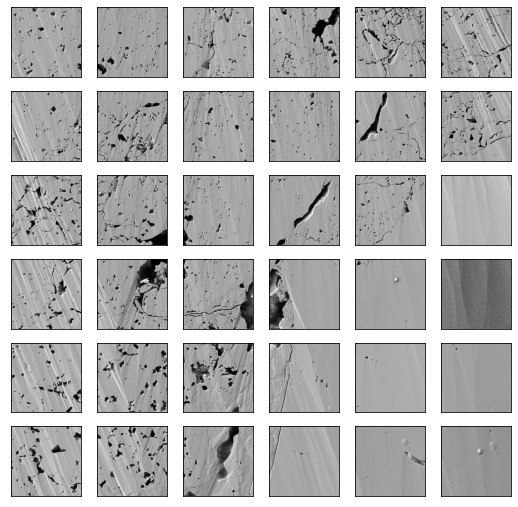

In [27]:
plt.figure(figsize=(9, 9))
square = 6
ix = 1
for i in range(square):
	for j in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot 
		plt.imshow(patches[i, j, :, :], cmap='gray')
		ix += 1
# show the figure
plt.show()

In [ ]:
predicted_patches = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        print("Now predicting on patch", i,j)
        
        single_patch = patches[i,j,:,:]  
        single_patch = single_patch / 255.  

        single_patch = np.expand_dims(np.array(single_patch), axis=2)
        single_patch_input=np.expand_dims(single_patch, 0)
        single_patch_prediction = (model.predict(single_patch_input))
        single_patch_predicted_img=np.argmax(single_patch_prediction, axis=3)[0,:,:]

        predicted_patches.append(single_patch_predicted_img)

predicted_patches = np.array(predicted_patches)

predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], 512,512)) #Replace with patch size

In [22]:
predicted_patches_reshaped.shape

(6, 8, 512, 512)

In [ ]:
plt.figure(figsize=(9, 9))
square = 6
ix = 1
for i in range(square):
	for j in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot 
		plt.imshow(predicted_patches_reshaped[i, j, :, :], cmap='gray')
		ix += 1
# show the figure
plt.show()

In [24]:
reconstructed_image = unpatchify(predicted_patches_reshaped, (3072, 4096))

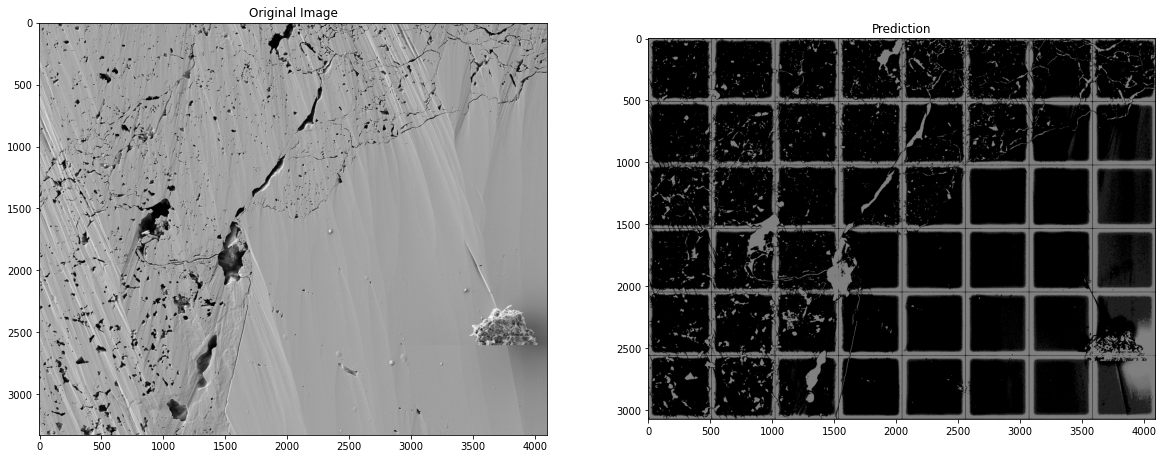

In [26]:
plt.figure(figsize=(20, 20))
plt.subplot(221)
plt.title('Original Image')
plt.imshow(img_for_test, cmap='gray')
plt.subplot(222)
plt.title('Prediction')
plt.imshow(reconstructed_image, cmap = 'gray')
plt.show()

### Predict on large image

In [ ]:
large_image = cv2.imread('../data/predictions/pred_test_2.tif', 0)
large_image_scaled = large_image /255.
large_image_scaled = np.expand_dims(large_image_scaled, axis=2)

large_image_scaled.shape


In [ ]:
scale_percent = 1 # percent of original size
width = int(large_image.shape[1] * scale_percent / 100)
height = int(large_image.shape[0] * scale_percent / 100)
dim = (width, height)

In [ ]:
smaller_image = cv2.resize(large_image, dim, interpolation=cv2.INTER_AREA)

In [ ]:
smaller_image_scaled = smaller_image /255.
smaller_image_scaled = np.expand_dims(smaller_image_scaled, axis=2)

In [ ]:
print('Resized Dimensions : ',smaller_image_scaled.shape)

In [ ]:
patch_size=512
n_classes=4

In [ ]:
#Load previously saved model
from keras.models import load_model
model = load_model("../models/05_27_onesample_10epochs.hdf5", compile=False)

In [ ]:
# Use the algorithm. The `pred_func` is passed and will process all the image 8-fold by tiling small patches with overlap, called once with all those image as a batch outer dimension.
# Note that model.predict(...) accepts a 4D tensor of shape (batch, x, y, nb_channels), such as a Keras model.
from smooth_tiled_pred import predict_img_with_smooth_windowing
predictions_smooth = predict_img_with_smooth_windowing(
    smaller_image_scaled,    #Must be of shape (x, y, c) --> NOT of the shape (n, x, y, c)
    window_size=patch_size,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=n_classes,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
    )
)

In [ ]:
print(predictions_smooth.shape)

In [ ]:
final_prediction = np.argmax(predictions_smooth, axis=2)

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(large_image, cmap='gray')
plt.subplot(132)
plt.title('Prediction without smooth blending')
plt.imshow(reconstructed_image)
plt.subplot(133)
plt.title('Prediction with smooth blending')
plt.imshow(final_prediction)
plt.show()

In [ ]:
# For later use?

In [ ]:
#Using built in keras function
y_pred=model.predict(img_for_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_argmax = np.argmax(mask_for_test, axis=3)

from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

In [ ]:
#Predict on a few images
import random
test_img_number = random.randint(0, len(test_image_batch)-1)
test_img = test_image_batch[test_img_number]
ground_truth=test_mask_batch[test_img_number]
ground_truth = np.argmax(ground_truth, axis=2)
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()